In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_ = pd.read_csv('../AirlineTweets.csv')

In [4]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = df_[['airline_sentiment', 'text']].copy()

In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

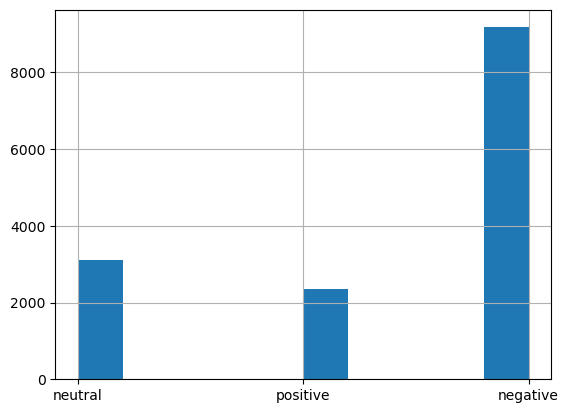

In [7]:
df['airline_sentiment'].hist()

In [8]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [23]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [46]:
#!type data.csv | head 10
!findstr /n "." data.csv | findstr "^.:"

1:sentence,label
2:@VirginAmerica What @dhepburn said.,2
3:@VirginAmerica plus you've added commercials to the experience... tacky.,1
4:@VirginAmerica I didn't today... Must mean I need to take another trip!,2
5:"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
6:@VirginAmerica and it's a really big bad thing about it,0
7:"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
8:it's really the only bad thing about flying VA",0
9:"@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€� wonâ€™t go away :)",1


In [47]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 106.78it/s]


Dataset csv downloaded and prepared to C:/Users/sthor/.cache/huggingface/datasets/csv/default-dc10d247c1ed8d6e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


In [58]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [59]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [60]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [61]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [62]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

In [63]:
checkpoint = 'distilbert-base-cased'

In [64]:
from transformers import AutoTokenizer

In [65]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sthor\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [66]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [67]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

In [68]:
from transformers import AutoModelForSequenceClassification, \
  Trainer, TrainingArguments

In [69]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [70]:
from torchinfo import summary

In [71]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [72]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [73]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [74]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [75]:
trainer.train()

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.544600,0.434911,0.831967,0.777788
2,0.342700,0.481638,0.832878,0.782342
3,0.239200,0.647335,0.833106,0.780988


TrainOutput(global_step=1923, training_loss=0.32670901928850593, metrics={'train_runtime': 111.7942, 'train_samples_per_second': 275.005, 'train_steps_per_second': 17.201, 'total_flos': 388376501242176.0, 'train_loss': 0.32670901928850593, 'epoch': 3.0})

In [76]:
!dir training_dir

 El volumen de la unidad C es Windows
 El número de serie del volumen es: 14FB-F245

 Directorio de C:\Users\sthor\Programas_codigo_fuente\Udemy\Data Science - Transformers for Natural Language Processing\Fine-Tuning (Intermediate)\training_dir

01/06/2023  18:37    <DIR>          .
01/06/2023  18:38    <DIR>          ..
01/06/2023  18:36    <DIR>          checkpoint-1282
01/06/2023  18:37    <DIR>          checkpoint-1923
01/06/2023  18:36    <DIR>          checkpoint-641
01/06/2023  18:35    <DIR>          runs
               0 archivos              0 bytes
               6 dirs  1,424,362,184,704 bytes libres


In [77]:
from transformers import pipeline

In [78]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [79]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [80]:
test_pred = savedmodel(split['test']['sentence'])

In [82]:
test_pred[0:10]

[{'label': 'LABEL_1', 'score': 0.967531144618988},
 {'label': 'LABEL_1', 'score': 0.9009507894515991},
 {'label': 'LABEL_0', 'score': 0.445819616317749},
 {'label': 'LABEL_1', 'score': 0.8773093223571777},
 {'label': 'LABEL_2', 'score': 0.9006239771842957},
 {'label': 'LABEL_0', 'score': 0.9955525994300842},
 {'label': 'LABEL_2', 'score': 0.8193354606628418},
 {'label': 'LABEL_2', 'score': 0.9834960103034973},
 {'label': 'LABEL_1', 'score': 0.7170244455337524},
 {'label': 'LABEL_0', 'score': 0.9957705140113831}]

In [83]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [84]:
test_pred[0:10]

[1, 1, 0, 1, 2, 0, 2, 2, 1, 0]

In [85]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8328779599271403


In [86]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7823420320831058


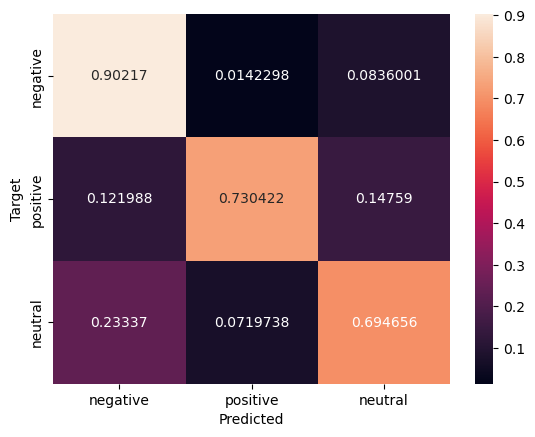

In [87]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

In [88]:
# Exercise: use binary classes and compare to pretrained pipeline from earlier